# Perform Classification on the ADNI dataset using SVMs

## Importing Stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import BatchSampler, SequentialSampler, RandomSampler
import time
try:
    import cPickle as thepickle
except ImportError:
    import _pickle as thepickle
from IPython.display import display
import pickle
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

## Read the data:

Instead of reading the whole database, we read only the data that's useful to us. That is, we read only specific columns of data, and we take only the row containing the first scan for each person. 

In "ADNI Regressional Analysis.ipynb" we have done that exactly, as well as performed linear regression transformation to the imaging data, in order to remove any age, sex, and DLICV_baseline effect. 

Furthermore, in "ADNI OPNMF.ipynb" we have performed dimensionality reduction through the OPNMF method, reducing the number of the ROIs from 145 to just 18. (Hasn't been done, so this does not apply)

Additionally, in "ADNI DeepCCA initial.ipynb" we have transformed the imaging and the genetic data using Deep Canonical Correlation Analysis to dimensionally reduced, maximally linearly correlated data. 

The data is located at "./DATA/ADNI_dataset.csv"
The transformed through LR data is located at "./DATA/Linearly_Transformed_Unique_Dataset.pkl"
The further transormed (through DCCA) data is located at "./DATA/ADNI_initial_DCCA_features.pkl"

(Need to run the RA and DCCA code if data is not found)

In [2]:
# Read the original data:
data = pd.read_csv("DATA/ADNI_dataset.csv", low_memory=False) # Need the low_memory or dtypes warning
data.replace({'Sex':{'F':1, 'M':0}}, inplace=True)

# The columns that interest us are the sex and age related, the ROIs, as well as the genetic data:
columns_of_interest = ['PTID',
                       'Date',
                       'Age', 
                       'Sex',
                       'DLICV_baseline',
                       'APOE4_Alleles',
                       'APOE_Genotype',
                       'Diagnosis_nearest_2.0']
c = list(data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]

columns_of_interest += MRI_columns + genetic_columns

# Need the dropna because some first PTIDs have no MRI
data_of_interest = data[columns_of_interest].dropna(subset=['MUSE_Volume_4', 'DLICV_baseline'])


unique = data_of_interest.drop_duplicates(subset=['PTID'], keep='first')
u = unique.dropna() # only 2 values in Diagnosis_nearest_2.0' have NaN, easier to drop them:
unique = u
unique['Diagnosis_nearest_2.0'] = unique['Diagnosis_nearest_2.0'].astype('category')
unique['Diagnosis_nearest_2.0_cat'] = unique['Diagnosis_nearest_2.0'].cat.codes
print(unique.shape)
unique.head(15)

(1567, 208)


,PTID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,MUSE_Volume_11,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,1873.124153,1586.249283,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,2131.516933,1505.034469,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,2366.717680,3157.732947,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,5124.734093,2981.605944,...,0,0,0,1,1,0,0,0,2,1
36,002_S_0685,2006-07-06,89.561644,1,1372862.125,0.0,E3/E3,CN,2941.520445,1693.826402,...,1,1,1,0,0,0,0,0,0,0
45,002_S_0729,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,966.095170,1921.643449,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1427.160586,1604.163157,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1931.131939,1136.952611,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,707.696352,2621.956978,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,2681.014413,1374.257191,...,1,0,0,0,1,0,0,0,1,1


In [3]:
# Read the data transformed through the Regressional Analysis:
lr_data = pd.read_pickle("./DATA/Linearly_Transformed_Unique_Dataset.pkl")
print(lr_data.shape)
lr_data.head(15)

(1302, 209)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,MUSE_Volume_4,...,rs111278892,rs3752246,rs4147929,rs41289512,rs3865444,rs6024870,rs6014724,rs7274581,rs429358,Diagnosis_nearest_2.0_cat
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,-401.428503,...,1,1,1,0,0,0,0,0,1,0
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,596.355045,...,0,1,1,0,1,0,0,0,0,0
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,224.874560,...,0,0,0,0,1,0,0,0,0,0
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,2633.277779,...,0,0,0,1,1,0,0,0,2,1
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,256.289641,...,0,0,0,1,1,0,0,0,1,2
64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,-126.260419,...,0,0,0,0,1,0,0,0,2,1
69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,200.102369,...,0,1,1,0,1,0,0,0,0,1
74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,-60.539913,...,2,1,1,0,1,0,0,0,1,2
81,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1058.028132,...,1,0,0,0,1,0,0,0,1,1
84,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,-485.048304,...,1,1,1,0,0,0,0,0,0,1


In [4]:
# Create a new dataset and drop the imaging and genetic data:
c = list(lr_data.columns)
MRI_columns = c[c.index("MUSE_Volume_4"):c.index("MUSE_Volume_207")+1]
genetic_columns = c[c.index("rs4575098"):c.index("rs429358")+1]
columns_to_drop = MRI_columns + genetic_columns
dcca_data = lr_data.drop(labels = columns_to_drop, axis=1)

# Read the data transformed through DCCA:
with open("./DATA/ADNI_initial_DCCA_features.pkl", 'rb') as f:
    dcca_transformed_data_file = pickle.load(f)
transformed_imaging_data = dcca_transformed_data_file[0]
transformed_genetic_data = dcca_transformed_data_file[1]
print("Transformed imaging data dimensions: \n" , transformed_imaging_data.shape)
print("Transformed genetic data dimensions: \n" , transformed_genetic_data.shape)

# Embed them into the new dataset:
imaging_labels = ["imaging_component_"+str(x+1) for x in range(transformed_imaging_data.shape[1])] 
genetic_labels = ["genetic_component_"+str(x+1) for x in range(transformed_genetic_data.shape[1])] 
dcca_data[genetic_labels] = transformed_genetic_data
dcca_data[imaging_labels] = transformed_imaging_data
print("DCCA Data Dimensions: \n",dcca_data.shape)
dcca_data.head(15)

Transformed imaging data dimensions: 
 (1302, 50)
Transformed genetic data dimensions: 
 (1302, 50)
DCCA Data Dimensions: 
 (1302, 110)


/var/folders/c9/121x4df174j1dqk40d8dkzvw0000gn/T/ipykernel_36699/421292000.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dcca_data[imaging_labels] = transformed_imaging_data
/var/folders/c9/121x4df174j1dqk40d8dkzvw0000gn/T/ipykernel_36699/421292000.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dcca_data[imaging_labels] = transformed_imaging_data
/var/folders/c9/121x4df174j1dqk40d8dkzvw0000gn/T/ipykernel_36699/421292000.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,...,0.265450,-0.588481,1.494160,0.464641,-0.464080,0.429959,-0.889877,2.429341,-1.496970,-4.961033
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,...,-0.258067,0.501793,-1.752262,-1.133469,-1.435080,2.133784,2.246922,1.358195,-1.712850,-3.594905
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,...,-0.866534,0.204544,1.261519,0.243370,-0.996479,0.513263,0.640849,3.994700,-0.652729,-5.405854
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,...,-2.367742,-1.426929,-1.775892,0.243927,-0.938351,-1.685831,0.941371,-3.021171,-1.171651,4.267579
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,...,-1.079121,2.071898,-2.648068,2.525044,-1.129323,1.334971,4.189767,1.001328,-2.864766,-2.184807
64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,...,-1.302565,0.370142,-1.022972,4.002663,-2.062786,-1.412294,0.224565,-1.582735,-1.250033,0.599805
69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,...,-0.744012,0.715234,-0.583494,-0.117094,-0.079651,0.871680,-0.726903,3.892656,0.357023,-4.085205
74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,...,-2.024902,-0.474762,-0.873614,1.842189,-0.073196,-2.014327,2.128241,2.425868,-0.404456,-4.454329
81,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,...,-0.808556,1.607881,-3.023479,1.542968,-0.623446,1.152979,4.360084,0.300277,-1.527782,-4.298677
84,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,...,-1.887000,-2.865357,3.209321,1.936926,-1.822992,-0.668024,-0.510700,2.820206,1.087956,-7.384209


## Perform Classification using SVMs:

In [10]:
def perform_svm(X,Y,kern= None, model=svm.LinearSVC(), params=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=False)
    
    
    clf = GridSearchCV(model, params, n_jobs=-1, cv=10)
    clf.fit(X_train,Y_train)
    print("Best Parameters for untrained data (",kern," kernel):",clf.best_params_)
    pred =  clf.predict(X_test)
    acc = accuracy_score(Y_test, pred)
    f1 = f1_score(Y_test, pred, average='weighted')
    cm = confusion_matrix(Y_test, pred, normalize='true')
    if kern == None:
        print('Accuracy (Linear Kernel): ', "%.2f" % (acc*100))
        print('F1 (Linear Kernel): ', "%.2f" % (f1*100))
    else:
        print('Accuracy ('+kern+' Kernel): ', "%.2f" % (acc*100))
        print('F1 ('+kern+' Kernel): ', "%.2f" % (f1*100))       
    return acc, f1, np.around(cm, decimals=2)

In [6]:
Accuracies = []
F1s = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

l, p, r = svm.LinearSVC(dual=False,max_iter=2000), svm.SVC(), svm.SVC()
l_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
p_params = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'degree':[2,3,4,5],
            'coef0':[0.0,10.0,100.0,1000.0],
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
r_params = {'C': [0.00001, 0.001, 0.01, 0.1, 1, 10], 
            'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

    
##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):

lin_accuracy, lin_f1, lin_cm = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_i = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_i = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d_i = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d_i = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_g = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_g = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g = perform_svm(X,Y, kern='linear', model=l, params=l_params)
poly_accuracy, poly_f1, poly_cm_d_g = perform_svm(X,Y,kern='poly', model=p, params=p_params)
rbf_accuracy, rbf_f1, rbf_cm_d_g = perform_svm(X,Y,kern='rbf', model=r, params=r_params)

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))

#################### IMAGING + GENETIC: ####################
Best Parameters for untrained data ( linear  kernel): {'C': 10}
Accuracy (linear Kernel):  49.81
F1 (linear Kernel):  49.77
Best Parameters for untrained data ( poly  kernel): {'C': 1e-05, 'coef0': 0.0, 'degree': 2, 'gamma': 0.0001}
Accuracy (poly Kernel):  51.34
F1 (poly Kernel):  34.83
Best Parameters for untrained data ( rbf  kernel): {'C': 1e-05, 'gamma': 0.0001}
Accuracy (rbf Kernel):  51.34
F1 (rbf Kernel):  34.83
#################### IMAGING + GENETIC DCCA: ####################
Best Parameters for untrained data ( linear  kernel): {'C': 10}
Accuracy (linear Kernel):  42.53
F1 (linear Kernel):  42.68
Best Parameters for untrained data ( poly  kernel): {'C': 1, 'coef0': 0.0, 'degree': 2, 'gamma': 0.001}
Accuracy (poly Kernel):  47.13
F1 (poly Kernel):  40.39
Best Parameters for untrained data ( rbf  kernel): {'C': 1, 'gamma': 0.001}
Accuracy (rbf Kernel):  47.13
F1 (rbf Kernel):  40.39
#################### IMAGING: #####

In [7]:
def barplot_scores(Accuracies, F1s, Names):
    barWidth = 0.2
    fig = plt.subplots(figsize =(14, 8))
    br1 = np.arange(len(Accuracies))
    br2 = [x + barWidth for x in br1] 
    plt.bar(br1, [100*x for x in Accuracies], color ='r', width = barWidth, edgecolor ='grey', label ='Accuracy')
    plt.bar(br2, [100*x for x in F1s], color ='b', width = barWidth, edgecolor ='grey', label ='F1 score')
    plt.xlabel('SVM', fontweight ='bold', fontsize = 15)
    plt.ylabel('Accuracy Score (%)', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(Accuracies))],Names)
    plt.grid()
    plt.legend()
    plt.show()
    return

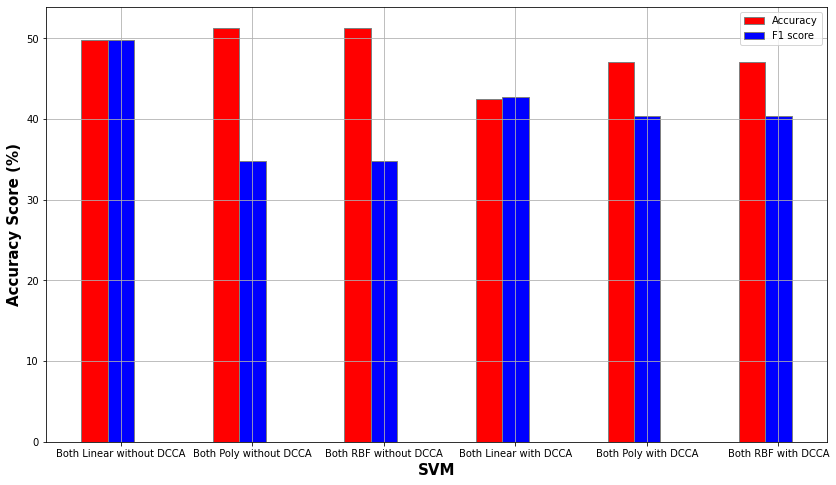

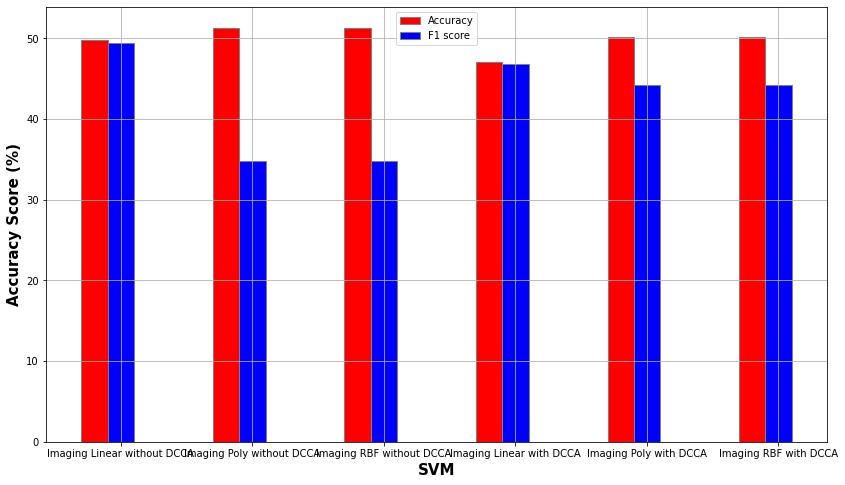

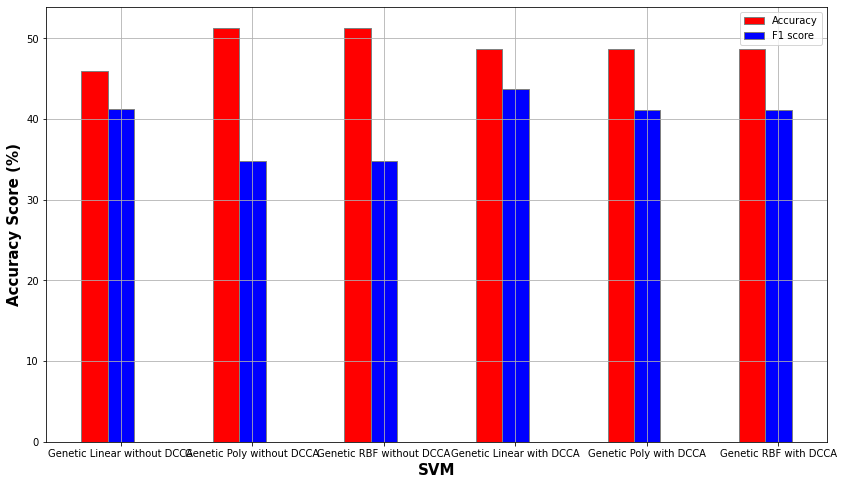

In [8]:
barplot_scores(Accuracies[0:6], F1s[0:6], 
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'])
barplot_scores(Accuracies[6:12], F1s[6:12], 
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'])
barplot_scores(Accuracies[12:18], F1s[12:18], 
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'])

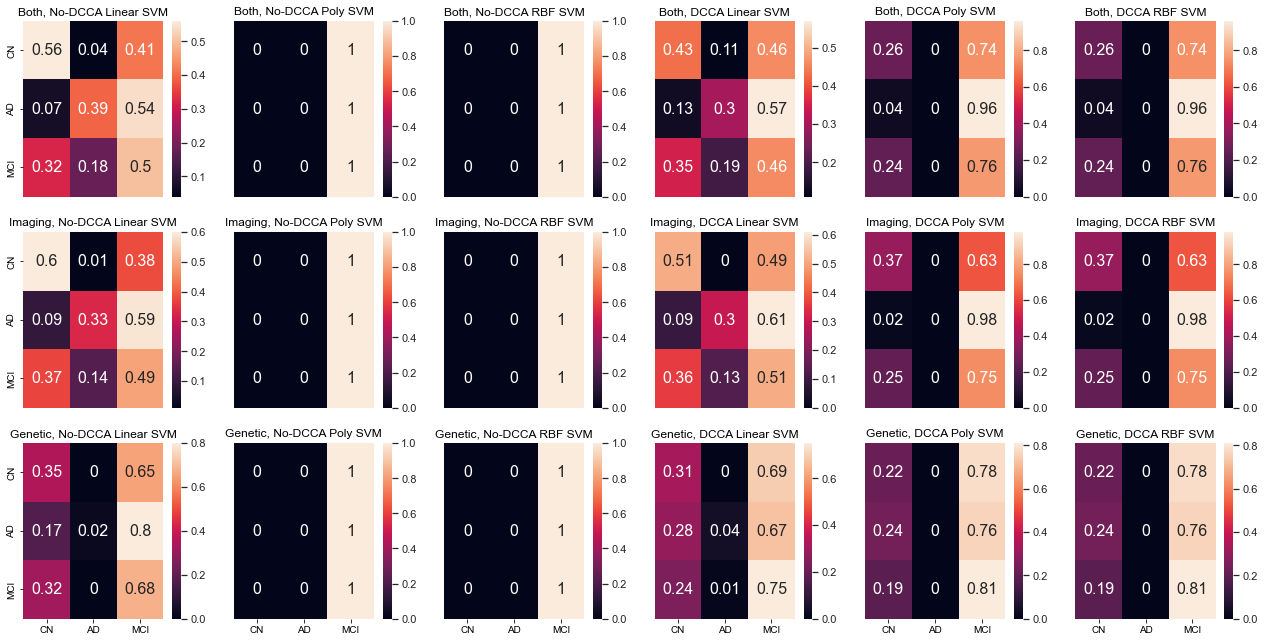

In [9]:
fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()


## Try with balancing & scaling:

In [5]:
# Scale the data:
scaler = preprocessing.StandardScaler()
dcca_data_scaled = scaler.fit_transform(dcca_data[imaging_labels + genetic_labels])
dcca_data[imaging_labels + genetic_labels] = dcca_data_scaled

# Balance the data through Undersampling - Use the same indexes as the LR Data:
dcca_data = dcca_data.loc[dcca_data['PTID'].isin(lr_data['PTID'])]

print(dcca_data.shape)
dcca_data.head(10)

(1302, 110)


,PTID,MRID,Date,Age,Sex,DLICV_baseline,APOE4_Alleles,APOE_Genotype,Diagnosis_nearest_2.0,Diagnosis_nearest_2.0_cat,...,imaging_component_41,imaging_component_42,imaging_component_43,imaging_component_44,imaging_component_45,imaging_component_46,imaging_component_47,imaging_component_48,imaging_component_49,imaging_component_50
0,002_S_0295,002_S_0295_2006-04-18,2006-04-18,84.742466,0,1485405.375,1.0,E3/E4,CN,0,...,0.157184,-0.337455,0.452002,0.245769,-0.352385,0.295731,-0.378660,1.199114,-0.887419,-1.413542
9,002_S_0413,002_S_0413_2006-05-02,2006-05-02,76.283562,1,1364116.000,0.0,E3/E3,CN,0,...,-0.179742,0.313501,-0.532730,-0.584095,-1.087212,1.405349,0.937182,0.671208,-1.014617,-1.029699
24,002_S_0559,002_S_0559_2006-05-23,2006-05-23,79.223288,0,1570479.625,1.0,E3/E4,CN,0,...,-0.571339,0.136026,0.381436,0.130868,-0.755290,0.349983,0.263458,1.970589,-0.389986,-1.538524
31,002_S_0619,002_S_0619_2006-06-01,2006-06-01,77.447945,0,1859348.250,2.0,E4/E4,Dementia,1,...,-1.537487,-0.838057,-0.539897,0.131157,-0.711300,-1.082178,0.389522,-1.487128,-0.695738,1.179437
45,002_S_0729,002_S_0729_2006-07-17,2006-07-17,65.056164,1,1166961.750,1.0,E3/E4,MCI,2,...,-0.708156,1.250944,-0.804453,1.315691,-0.855824,0.885121,1.752177,0.495329,-1.693334,-0.633501
64,002_S_0816,002_S_0816_2006-08-30,2006-08-30,70.767123,0,1444128.125,2.0,E4/E4,Dementia,1,...,-0.851960,0.234898,-0.311515,2.082986,-1.562243,-0.904037,0.088832,-0.778207,-0.741921,0.148896
69,002_S_0938,002_S_0938_2006-10-05,2006-10-05,82.167123,1,1309685.000,0.0,E3/E3,Dementia,1,...,-0.492486,0.440937,-0.178209,-0.056313,-0.061459,0.583402,-0.310295,1.920298,0.204968,-1.167459
74,002_S_0954,002_S_0954_2006-10-10,2006-10-10,69.198630,1,1075661.500,1.0,E3/E4,MCI,2,...,-1.316842,-0.269559,-0.266211,0.961099,-0.056573,-1.296111,0.887397,1.197403,-0.243701,-1.271172
81,002_S_0955,002_S_0955_2006-10-11,2006-10-11,78.161644,1,1363607.000,1.0,E3/E4,Dementia,1,...,-0.534026,0.973899,-0.918326,0.805721,-0.472989,0.766599,1.823622,0.149822,-0.905573,-1.227439
84,002_S_1018,002_S_1018_2006-11-29,2006-11-29,70.658904,1,1355603.000,0.0,E3/E3,Dementia,1,...,-1.228091,-1.696881,0.972259,1.010294,-1.380774,-0.419331,-0.219600,1.391749,0.635639,-2.094386


### Perform Classification using SVMs:

In [16]:
Accuracies = []
F1s = []
# LinearSVC: one-vs-the-rest scheme.
# SVC: one-vs-one scheme.

##############################################################################  IMAGING + GENETIC without DCCA:
print("#################### IMAGING + GENETIC: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns + genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING + GENETIC with DCCA:
print("#################### IMAGING + GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels + imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  IMAGING ONLY without DCCA:
print("#################### IMAGING: ####################")
# Get the values that interest us:
X = lr_data[MRI_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_i = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## IMAGING ONLY with DCCA:
print("#################### IMAGING DCCA: ####################")
# Get the values that interest us:
X = dcca_data[imaging_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_i = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d_i = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_i = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

##############################################################################  GENETIC ONLY without DCCA:
print("#################### GENETIC: ####################")
# Get the values that interest us:
X = lr_data[genetic_columns]
Y = lr_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_g = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

############################################################################## GENETIC ONLY with DCCA:
print("#################### GENETIC DCCA: ####################")
# Get the values that interest us:
X = dcca_data[genetic_labels]
Y = dcca_data["Diagnosis_nearest_2.0_cat"]

# Create 3 separate kernels for experimentation (increase max_iter because of warning):
lin_accuracy, lin_f1, lin_cm_d_g = perform_svm(X,Y, kern='linear')
poly_accuracy, poly_f1, poly_cm_d_g = perform_svm(X,Y,kern='poly')
rbf_accuracy, rbf_f1, rbf_cm_d_g = perform_svm(X,Y,kern='rbf')

Accuracies += lin_accuracy, poly_accuracy, rbf_accuracy
F1s += lin_f1, poly_f1, rbf_f1

names = ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
         'Both Poly with DCCA', 'Both RBF with DCCA', 'Imaging Linear without DCCA', 'Imaging Poly without DCCA',
         'Imaging RBF without DCCA','Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA',
         'Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 'Genetic Linear with DCCA',
         'Genetic Poly with DCCA', 'Genetic RBF with DCCA']

max_acc = np.argmax(Accuracies)
print("Model with max Accuracy: ", names[max_acc], " with an Accuracy score of ", round(max(Accuracies)*100,3))
max_f1 = np.argmax(F1s)
print("Model with max F1 Score: ", names[max_f1], " with an F1 Score of ", round(max(F1s)*100,3))

#################### IMAGING + GENETIC: ####################
Accuracy (linear Kernel):  52.15
F1 (linear Kernel):  50.93
Accuracy (poly Kernel):  47.85
F1 (poly Kernel):  45.34
Accuracy (rbf Kernel):  52.69
F1 (rbf Kernel):  51.77
#################### IMAGING + GENETIC DCCA: ####################
Accuracy (linear Kernel):  47.31
F1 (linear Kernel):  46.77
Accuracy (poly Kernel):  44.62
F1 (poly Kernel):  43.63
Accuracy (rbf Kernel):  43.55
F1 (rbf Kernel):  43.11
#################### IMAGING: ####################
Accuracy (linear Kernel):  56.45
F1 (linear Kernel):  55.89
Accuracy (poly Kernel):  47.85
F1 (poly Kernel):  45.33
Accuracy (rbf Kernel):  51.08
F1 (rbf Kernel):  50.44
#################### IMAGING DCCA: ####################
Accuracy (linear Kernel):  46.77
F1 (linear Kernel):  45.99
Accuracy (poly Kernel):  45.16
F1 (poly Kernel):  44.37
Accuracy (rbf Kernel):  46.24
F1 (rbf Kernel):  45.50
#################### GENETIC: ####################
Accuracy (linear Kernel):  43.55
F1

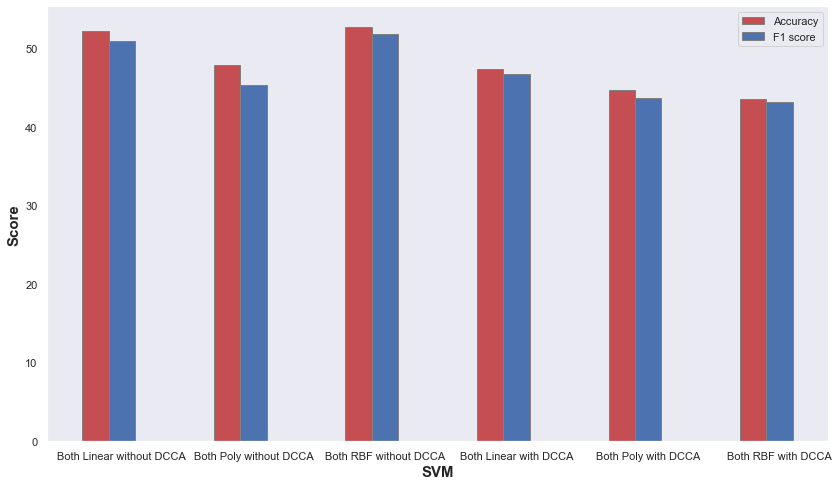

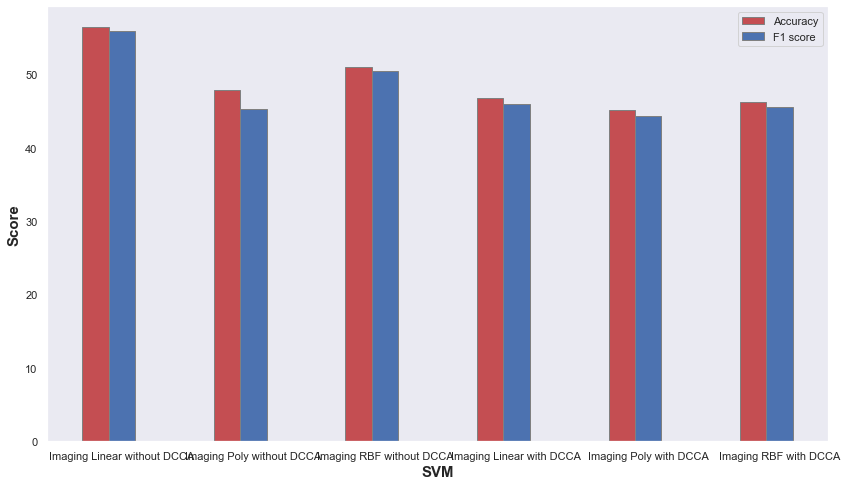

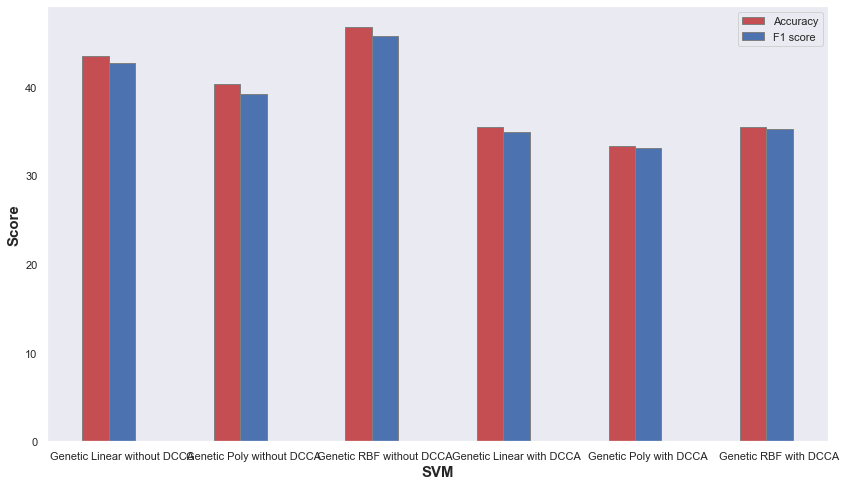

In [17]:
barplot_scores(Accuracies[0:6], F1s[0:6], 
               ['Both Linear without DCCA', 'Both Poly without DCCA', 'Both RBF without DCCA', 'Both Linear with DCCA',
                'Both Poly with DCCA', 'Both RBF with DCCA'])
barplot_scores(Accuracies[6:12], F1s[6:12], 
               ['Imaging Linear without DCCA', 'Imaging Poly without DCCA', 'Imaging RBF without DCCA',
                'Imaging Linear with DCCA', 'Imaging Poly with DCCA', 'Imaging RBF with DCCA'])
barplot_scores(Accuracies[12:18], F1s[12:18], 
               ['Genetic Linear without DCCA', 'Genetic Poly without DCCA', 'Genetic RBF without DCCA', 
                'Genetic Linear with DCCA','Genetic Poly with DCCA', 'Genetic RBF with DCCA'])

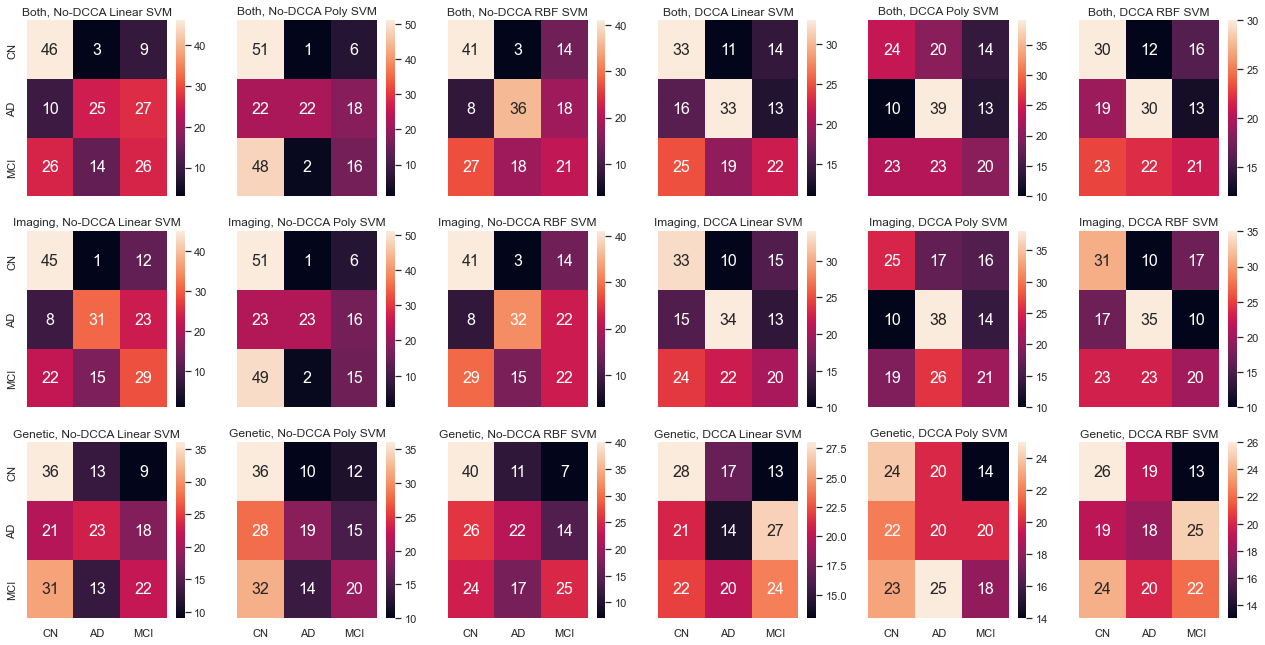

In [18]:
# Test size is 186

fig, axes = plt.subplots(nrows=3,ncols=6,figsize=(22,11));
sns.set(font_scale=1) # for label size
sns.heatmap(lin_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Both, No-DCCA Linear SVM")
sns.heatmap(poly_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA Poly SVM")
sns.heatmap(rbf_cm, annot=True, annot_kws={"size": 16}, ax = axes[0][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Linear SVM")
sns.heatmap(poly_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA Poly SVM")
sns.heatmap(rbf_cm_d, annot=True, annot_kws={"size": 16}, ax = axes[0][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Both, DCCA RBF SVM")
###
sns.heatmap(lin_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][0], fmt='g',
           xticklabels = False, yticklabels = ["CN", "AD", "MCI"]).set_title("Imaging, No-DCCA Linear SVM")
sns.heatmap(poly_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][1], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_i, annot=True, annot_kws={"size": 16}, ax = axes[1][2], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][3], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Linear SVM")
sns.heatmap(poly_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][4], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_i, annot=True, annot_kws={"size": 16}, ax = axes[1][5], fmt='g',
           xticklabels = False, yticklabels = False).set_title("Imaging, DCCA RBF SVM")
###
sns.heatmap(lin_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][0], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = ["CN", "AD", "MCI"]).set_title("Genetic, No-DCCA Linear SVM")
sns.heatmap(poly_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][1], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA Poly SVM")
sns.heatmap(rbf_cm_g, annot=True, annot_kws={"size": 16}, ax = axes[2][2], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, No-DCCA RBF SVM")
sns.heatmap(lin_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][3], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Linear SVM")
sns.heatmap(poly_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][4], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA Poly SVM")
sns.heatmap(rbf_cm_d_g, annot=True, annot_kws={"size": 16}, ax = axes[2][5], fmt='g',
           xticklabels = ["CN", "AD", "MCI"], yticklabels = False).set_title("Genetic, DCCA RBF SVM")
plt.show()